# Notebook 2: The Clustering Theorem

**Duration**: 2-3 hours  
**Prerequisites**: Notebook 1

This notebook explores **Theorem 1** of the Rigollet paper: the remarkable result that for almost every initial condition, all tokens eventually collapse to a single cluster. We'll understand why this happens and what it means for real transformers.

---

## Learning Objectives

By the end of this notebook, you should be able to:

- [ ] State Theorem 1 (global clustering) in plain language
- [ ] Understand why clustering is "almost sure" (saddle point analysis)
- [ ] Derive local exponential rates from Theorem 3
- [ ] Connect to representation collapse in deep networks

---

## Connection to Your Work

**This explains representation collapse.** If you use a model with too many layers or too high β, your metabolite embeddings become indistinguishable. The theory predicts this will happen eventually for ANY model—the question is whether it happens before or after useful semantic structure is captured.

In [1]:
# Core imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, Markdown

# Visualization setup
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

# Import our utilities
from utils import (
    random_sphere_points,
    hemisphere_initialization,
    simulate_sa,
    simulate_usa,
    pairwise_similarity_dist,
    compute_cluster_metric,
    compute_energy,
    detect_clusters,
    plot_sphere_3d,
    plot_similarity_evolution,
    plot_similarity_histogram,
    plot_energy_staircase
)

np.random.seed(42)
print("Imports loaded successfully!")

Imports loaded successfully!


---

## 1. Theorem 1: Global Clustering

### The Statement (Plain Language)

> **Theorem 1 (Rigollet et al.)**: For almost every initial condition, all tokens converge to a single cluster:
> $$\lim_{t \to \infty} \|x_i(t) - x_j(t)\| = 0$$

### What This Means

1. **"Almost every"**: Except for a measure-zero set of special initializations (unstable equilibria)
2. **"Single cluster"**: All $n$ particles end up at the same point on the sphere
3. **"Any β ≥ 0"**: This holds for any temperature, not just high β
4. **"Dimension d ≥ 3"**: Holds for realistic embedding dimensions

### The Surprising Implication

If transformers ran forever, **all embeddings would become identical**. This is representation collapse—the loss of all discriminative information!

Why do real transformers still work? Because:
1. They have finite layers (finite time)
2. Useful structure lives in **metastable states** (Notebook 3)

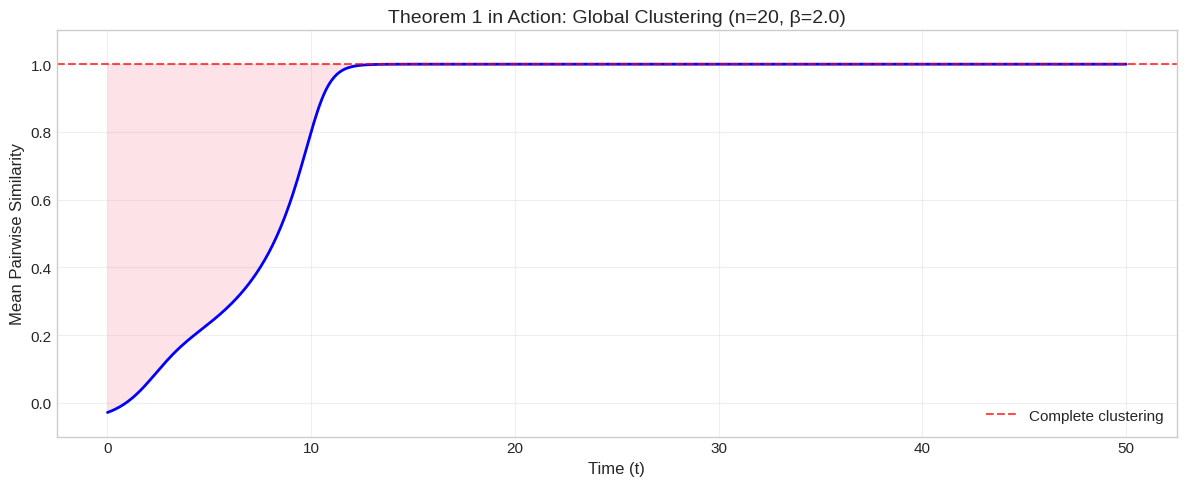

Final clustering metric: 1.000000
Approaching 1.0 = all particles at same point!


In [2]:
# Demonstrate Theorem 1: Convergence to single cluster

n_particles = 20
d = 3
beta = 2.0
t_end = 50.0  # Long simulation

X0 = random_sphere_points(n_particles, d, seed=42)
times, trajectory = simulate_sa(X0, beta, (0, t_end), n_steps=500)

# Track clustering over time
clustering_metrics = [compute_cluster_metric(trajectory[i]) for i in range(len(times))]

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(times, clustering_metrics, 'b-', linewidth=2)
ax.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='Complete clustering')
ax.fill_between(times, clustering_metrics, 1.0, alpha=0.2)
ax.set_xlabel('Time (t)', fontsize=12)
ax.set_ylabel('Mean Pairwise Similarity', fontsize=12)
ax.set_title(f'Theorem 1 in Action: Global Clustering (n={n_particles}, β={beta})', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()

print(f"Final clustering metric: {clustering_metrics[-1]:.6f}")
print(f"Approaching 1.0 = all particles at same point!")

/tmp/ipykernel_2221457/2076549378.py:26: UserWarning: Glyph 10216 (\N{MATHEMATICAL LEFT ANGLE BRACKET}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_2221457/2076549378.py:26: UserWarning: Glyph 11388 (\N{LATIN SUBSCRIPT SMALL LETTER J}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_2221457/2076549378.py:26: UserWarning: Glyph 10217 (\N{MATHEMATICAL RIGHT ANGLE BRACKET}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/home/trentleslie/Insync/projects/biovector-eval/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10216 (\N{MATHEMATICAL LEFT ANGLE BRACKET}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/trentleslie/Insync/projects/biovector-eval/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11388 (\N{LATIN SUBSCRIPT SMALL LETTER J}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, 

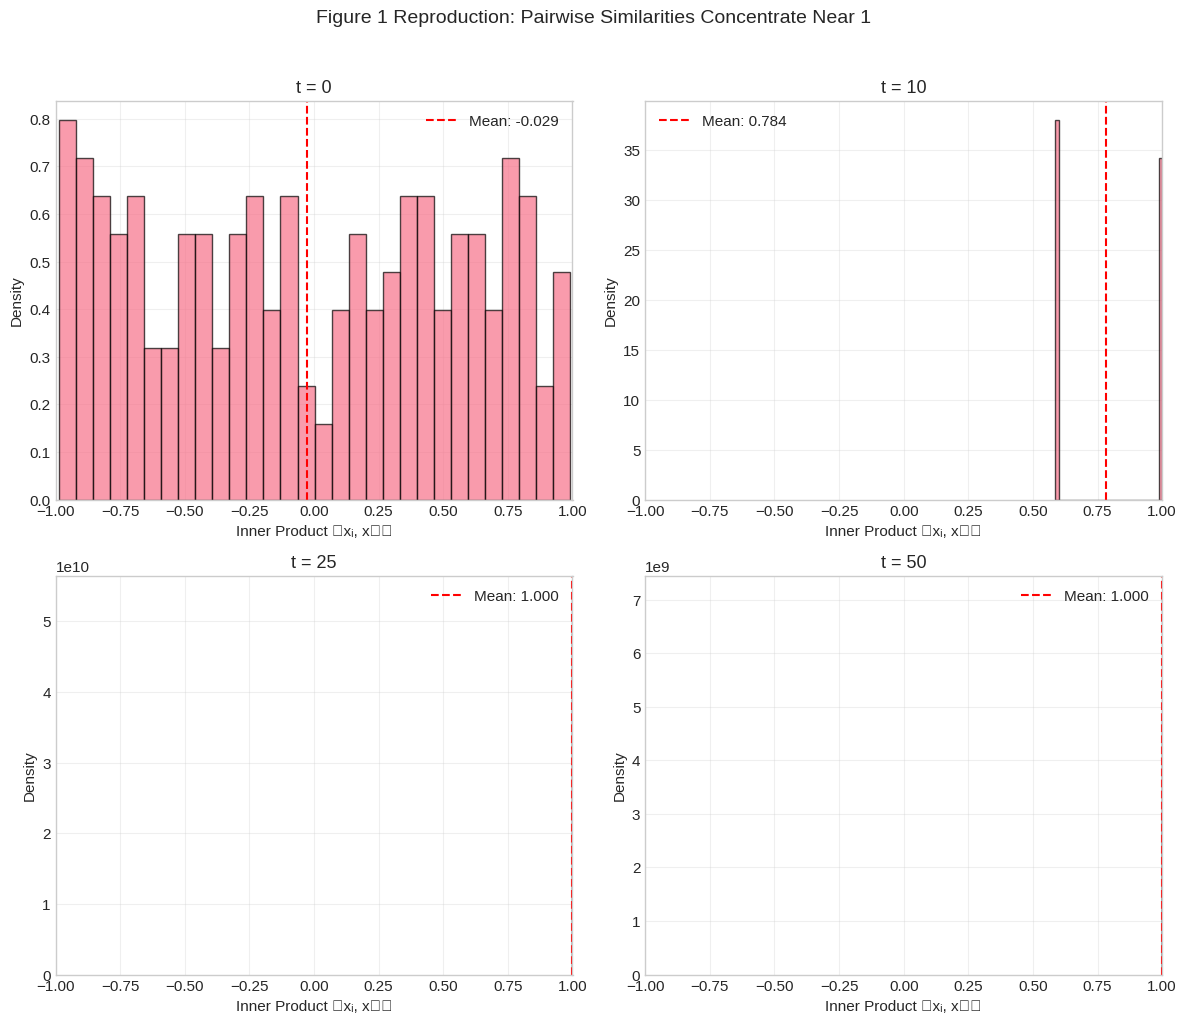

Key observation: The distribution shifts rightward and concentrates near 1.0
This is Theorem 1 visualized—all pairwise similarities approaching 1.


In [3]:
# Reproduce Figure 1 from the paper:
# Distribution of pairwise inner products concentrating near 1

# Sample at different times
sample_times = [0, 10, 25, 50]
sample_indices = [int(t / t_end * (len(times) - 1)) for t in sample_times]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, (t_idx, t_val) in enumerate(zip(sample_indices, sample_times)):
    sims = pairwise_similarity_dist(trajectory[t_idx])
    
    axes[idx].hist(sims, bins=30, density=True, alpha=0.7, edgecolor='black')
    axes[idx].axvline(x=np.mean(sims), color='r', linestyle='--', 
                      label=f'Mean: {np.mean(sims):.3f}')
    axes[idx].set_xlabel('Inner Product ⟨xᵢ, xⱼ⟩', fontsize=11)
    axes[idx].set_ylabel('Density', fontsize=11)
    axes[idx].set_title(f't = {t_val}', fontsize=13)
    axes[idx].set_xlim(-1, 1)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Figure 1 Reproduction: Pairwise Similarities Concentrate Near 1', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("Key observation: The distribution shifts rightward and concentrates near 1.0")
print("This is Theorem 1 visualized—all pairwise similarities approaching 1.")

---

## 2. Why Clustering Happens: The Energy Perspective

### The Energy Functional

The SA/USA dynamics are **gradient flows** of an energy functional:

$$E_\beta(X) = \frac{1}{2\beta} \sum_{i,j} \exp(\beta \langle x_i, x_j \rangle)$$

This means particles move to **minimize energy**, and the only minimum is the fully clustered state.

### Stable vs Unstable Equilibria

| Configuration | Energy | Stability |
|--------------|--------|----------|
| All particles at one point | Minimum | **Stable** |
| Evenly distributed on sphere | Maximum | Saddle (unstable) |
| Any other configuration | Intermediate | Flows toward minimum |

The "almost every" in Theorem 1 excludes the saddle points—unstable equilibria that exist but are never reached from generic initial conditions.

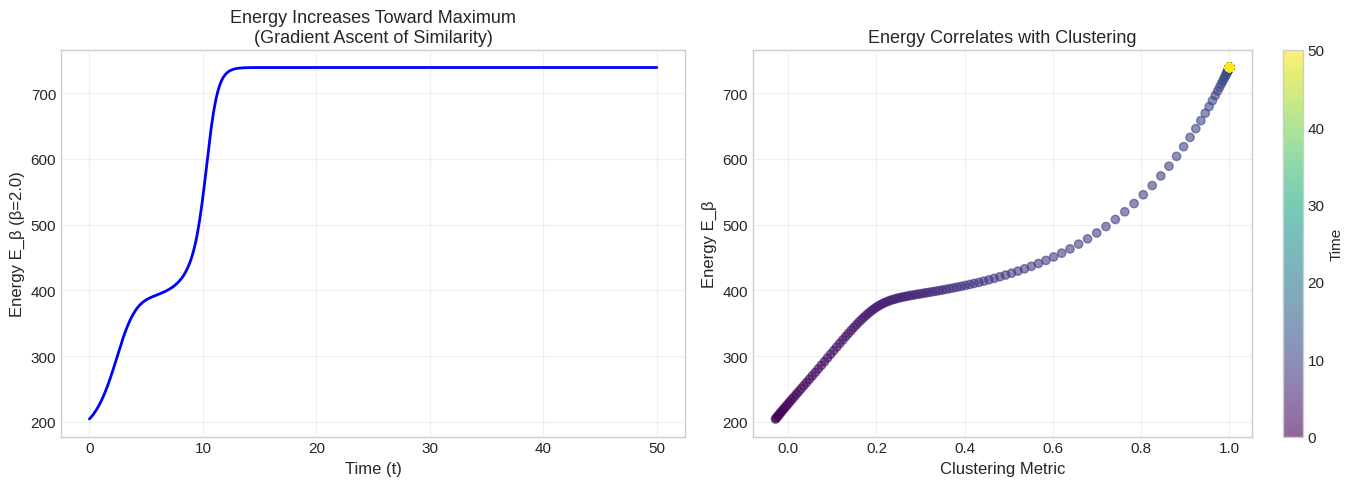

Initial energy: 204.22
Final energy: 738.91

Note: Energy INCREASES because we're maximizing similarity!


In [4]:
# Track energy evolution

energies = [compute_energy(trajectory[i], beta) for i in range(len(times))]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Energy over time
axes[0].plot(times, energies, 'b-', linewidth=2)
axes[0].set_xlabel('Time (t)', fontsize=12)
axes[0].set_ylabel(f'Energy E_β (β={beta})', fontsize=12)
axes[0].set_title('Energy Increases Toward Maximum\n(Gradient Ascent of Similarity)', fontsize=13)
axes[0].grid(True, alpha=0.3)

# Correlation: energy vs clustering
axes[1].scatter(clustering_metrics, energies, c=times, cmap='viridis', alpha=0.6)
axes[1].set_xlabel('Clustering Metric', fontsize=12)
axes[1].set_ylabel(f'Energy E_β', fontsize=12)
axes[1].set_title('Energy Correlates with Clustering', fontsize=13)
cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar.set_label('Time')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Initial energy: {energies[0]:.2f}")
print(f"Final energy: {energies[-1]:.2f}")
print("\nNote: Energy INCREASES because we're maximizing similarity!")

---

## 3. Convergence Rates (Theorem 3)

### Local Exponential Convergence

**Theorem 3** gives us convergence rates when particles start "close enough":

> If all tokens start in the same hemisphere (e.g., $x_{i,1} > 0$ for all $i$), then convergence is **exponential**:
> $$\|x_i(t) - x^*\| \leq C e^{-\lambda t}$$

### What Affects the Rate?

| Factor | Effect on Rate |
|--------|---------------|
| Higher β | Faster convergence |
| Tighter initial clustering | Faster convergence |
| More particles | Slight slowdown |

### Practical Implication

If your metabolites start in a coherent region of embedding space (e.g., "all lipids"), they'll cluster faster than if they start spread across the sphere (e.g., "random assortment").

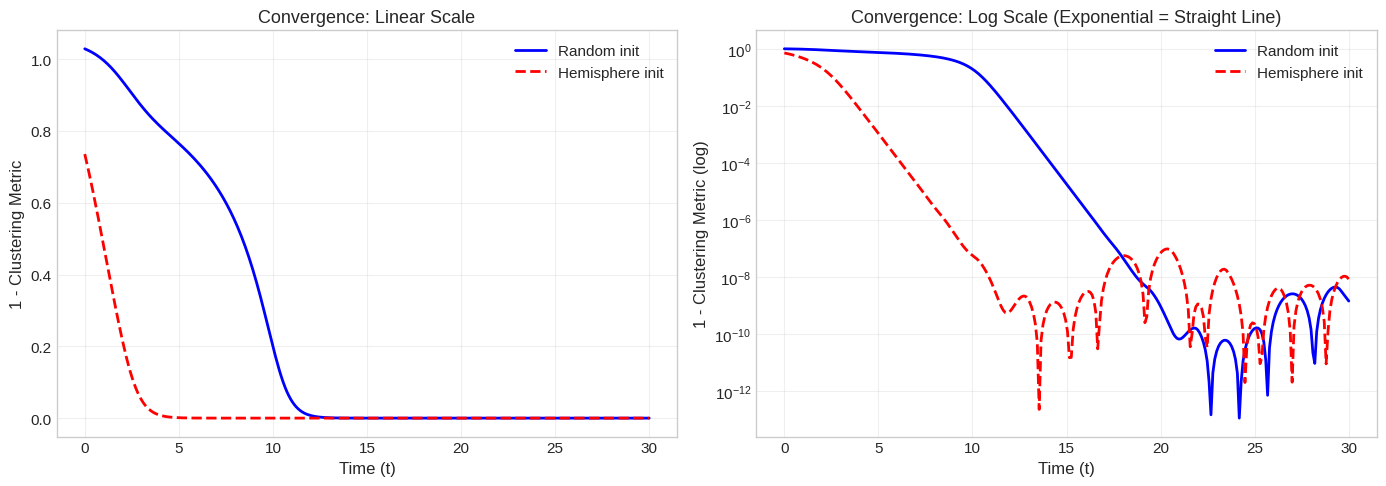

Observation: Hemisphere initialization (all particles in same hemisphere)
shows more clearly exponential convergence (straighter line on log scale).


In [5]:
# Compare: hemisphere initialization vs random initialization

n = 20
d = 3
beta = 2.0
t_end = 30.0

# Two initializations
X_random = random_sphere_points(n, d, seed=42)
X_hemisphere = hemisphere_initialization(n, d, seed=42)

# Run simulations
t1, traj_random = simulate_sa(X_random, beta, (0, t_end), n_steps=300)
t2, traj_hemisphere = simulate_sa(X_hemisphere, beta, (0, t_end), n_steps=300)

# Track 1 - clustering
cluster_random = [1 - compute_cluster_metric(traj_random[i]) for i in range(len(t1))]
cluster_hemi = [1 - compute_cluster_metric(traj_hemisphere[i]) for i in range(len(t2))]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
axes[0].plot(t1, cluster_random, 'b-', linewidth=2, label='Random init')
axes[0].plot(t2, cluster_hemi, 'r--', linewidth=2, label='Hemisphere init')
axes[0].set_xlabel('Time (t)', fontsize=12)
axes[0].set_ylabel('1 - Clustering Metric', fontsize=12)
axes[0].set_title('Convergence: Linear Scale', fontsize=13)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Log scale (should show exponential as straight line)
axes[1].semilogy(t1, cluster_random, 'b-', linewidth=2, label='Random init')
axes[1].semilogy(t2, cluster_hemi, 'r--', linewidth=2, label='Hemisphere init')
axes[1].set_xlabel('Time (t)', fontsize=12)
axes[1].set_ylabel('1 - Clustering Metric (log)', fontsize=12)
axes[1].set_title('Convergence: Log Scale (Exponential = Straight Line)', fontsize=13)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observation: Hemisphere initialization (all particles in same hemisphere)")
print("shows more clearly exponential convergence (straighter line on log scale).")

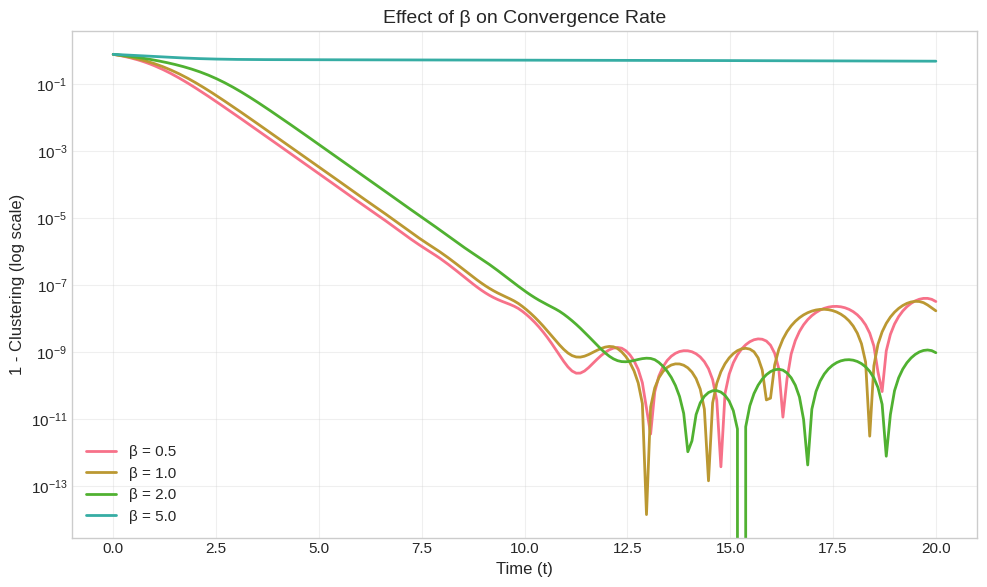

Key insight: Higher β → steeper slope → faster convergence
This matches Theorem 3's prediction about exponential rates.


In [6]:
# How β affects convergence rate

betas = [0.5, 1.0, 2.0, 5.0]
t_end = 20.0
X0 = hemisphere_initialization(15, 3, seed=42)

fig, ax = plt.subplots(figsize=(10, 6))

for beta in betas:
    times, trajectory = simulate_sa(X0, beta, (0, t_end), n_steps=200)
    gap = [1 - compute_cluster_metric(trajectory[i]) for i in range(len(times))]
    ax.semilogy(times, gap, linewidth=2, label=f'β = {beta}')

ax.set_xlabel('Time (t)', fontsize=12)
ax.set_ylabel('1 - Clustering (log scale)', fontsize=12)
ax.set_title('Effect of β on Convergence Rate', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key insight: Higher β → steeper slope → faster convergence")
print("This matches Theorem 3's prediction about exponential rates.")

---

## 4. Representation Collapse

### The Problem in Deep Networks

**Representation collapse** is when deep network embeddings lose discriminative power—all inputs get mapped to nearly identical representations.

Theorem 1 explains this mathematically:
- Attention dynamics → clustering
- More layers → more time for dynamics
- Eventually → all embeddings identical

### Why Some Models Collapse More Than Others

| Model | Layers | Risk |
|-------|--------|------|
| ChemBERTa | 6 | Lower (less time for collapse) |
| SapBERT | 12 | Medium |
| GPT-4 | ~100+ | High (but mitigated by Pre-LN) |

The paper's analysis of normalization schemes (Notebook 5) explains how Pre-LN slows collapse.

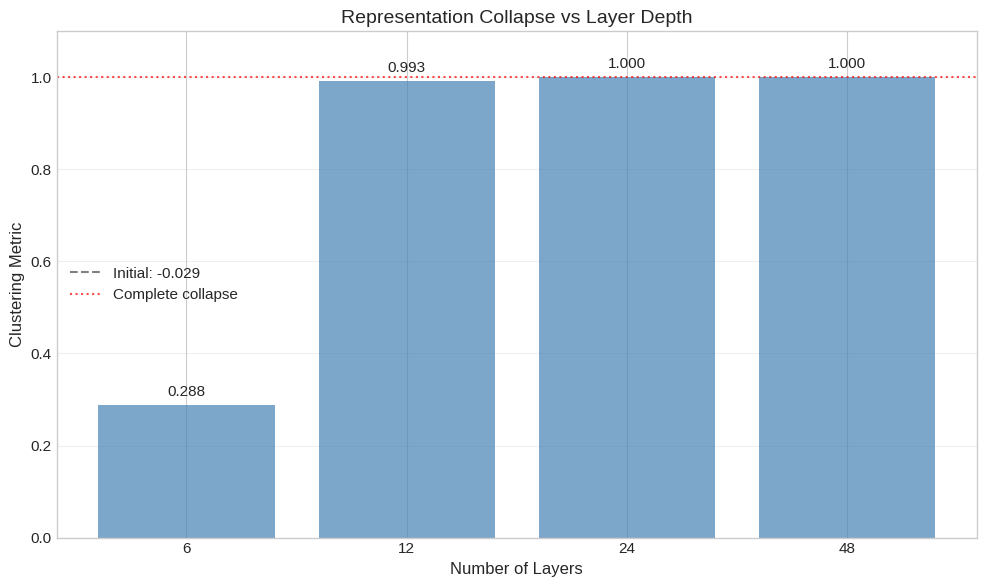

Observation: More layers → higher clustering → more representation collapse
This is why very deep models need careful normalization design!


In [7]:
# Simulate "layer count" effect
# More layers = more time in continuous dynamics

layer_counts = [6, 12, 24, 48]  # Like different model depths
beta = 2.0

# Map layers to time (rough heuristic: each layer ≈ 1 time unit)
X0 = random_sphere_points(20, 3, seed=42)

final_clusterings = []
initial_clustering = compute_cluster_metric(X0)

for n_layers in layer_counts:
    # Simulate
    _, traj = simulate_sa(X0, beta, (0, n_layers), n_steps=100)
    final_clusterings.append(compute_cluster_metric(traj[-1]))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar([str(l) for l in layer_counts], final_clusterings, color='steelblue', alpha=0.7)
ax.axhline(y=initial_clustering, color='gray', linestyle='--', 
           label=f'Initial: {initial_clustering:.3f}')
ax.axhline(y=1.0, color='red', linestyle=':', alpha=0.7, label='Complete collapse')

ax.set_xlabel('Number of Layers', fontsize=12)
ax.set_ylabel('Clustering Metric', fontsize=12)
ax.set_title('Representation Collapse vs Layer Depth', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 1.1)

# Add values on bars
for i, v in enumerate(final_clusterings):
    ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=11)

plt.tight_layout()
plt.show()

print("Observation: More layers → higher clustering → more representation collapse")
print("This is why very deep models need careful normalization design!")

---

## 5. Interactive Exploration

In [8]:
# Interactive exploration of clustering dynamics

def explore_clustering(n_particles, beta, t_end, seed):
    """Explore clustering with different parameters."""
    
    X0 = random_sphere_points(n_particles, 3, seed=seed)
    times, trajectory = simulate_sa(X0, beta, (0, t_end), n_steps=200)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # 1. Clustering over time
    clustering = [compute_cluster_metric(trajectory[i]) for i in range(len(times))]
    axes[0].plot(times, clustering, 'b-', linewidth=2)
    axes[0].axhline(y=1.0, color='r', linestyle='--', alpha=0.5)
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Clustering Metric')
    axes[0].set_title('Clustering Evolution')
    axes[0].set_ylim(-0.2, 1.1)
    axes[0].grid(True, alpha=0.3)
    
    # 2. Initial distribution
    init_sims = pairwise_similarity_dist(trajectory[0])
    axes[1].hist(init_sims, bins=25, density=True, alpha=0.7, label='Initial')
    axes[1].axvline(x=np.mean(init_sims), color='b', linestyle='--')
    final_sims = pairwise_similarity_dist(trajectory[-1])
    axes[1].hist(final_sims, bins=25, density=True, alpha=0.7, label='Final')
    axes[1].axvline(x=np.mean(final_sims), color='orange', linestyle='--')
    axes[1].set_xlabel('Pairwise Similarity')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Distribution Shift')
    axes[1].legend()
    axes[1].set_xlim(-1, 1)
    axes[1].grid(True, alpha=0.3)
    
    # 3. Number of clusters over time
    thresholds = [0.7, 0.8, 0.9, 0.95]
    for thresh in thresholds:
        n_clusters = [len(detect_clusters(trajectory[i], thresh)) for i in range(0, len(times), 10)]
        axes[2].plot(times[::10], n_clusters, 'o-', label=f'thresh={thresh}')
    
    axes[2].set_xlabel('Time')
    axes[2].set_ylabel('Number of Clusters')
    axes[2].set_title('Cluster Count (Different Thresholds)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nFinal clustering: {clustering[-1]:.4f}")
    print(f"Initial mean similarity: {np.mean(init_sims):.4f}")
    print(f"Final mean similarity: {np.mean(final_sims):.4f}")

# Widgets
widgets.interact(
    explore_clustering,
    n_particles=widgets.IntSlider(value=20, min=5, max=50, step=5, description='Particles:'),
    beta=widgets.FloatSlider(value=2.0, min=0.5, max=10.0, step=0.5, description='β:'),
    t_end=widgets.FloatSlider(value=30.0, min=5.0, max=100.0, step=5.0, description='Time:'),
    seed=widgets.IntSlider(value=42, min=1, max=100, step=1, description='Seed:')
)

interactive(children=(IntSlider(value=20, description='Particles:', max=50, min=5, step=5), FloatSlider(value=…

<function __main__.explore_clustering(n_particles, beta, t_end, seed)>

---

## Summary: The Clustering Theorem

### Key Results

| Theorem | Statement | Implication |
|---------|-----------|-------------|
| **Theorem 1** | All tokens converge to single cluster | Representation collapse is inevitable |
| **Theorem 3** | Exponential convergence in hemisphere | Coherent inputs cluster faster |
| **Energy** | Dynamics minimize energy functional | Clustering is thermodynamically favored |

### Why Real Models Still Work

If everything collapses, why do embeddings have useful structure?

1. **Finite layers**: Real models have 6-100 layers, not infinite
2. **Metastability**: Before full collapse, there are long-lived multi-cluster states
3. **Normalization**: Pre-LN slows collapse (Notebook 5)

### Connection to Your Work

The clustering theorem explains why:
- Similar metabolites (lipids, sugars) form embedding clusters
- Very deep models might over-cluster (lose specificity)
- The useful semantic structure lives in the **metastable regime** before full collapse

---

## Next: Notebook 3 - Metastability and Multiple Clusters

We'll explore why clustering doesn't happen all at once—there are long-lived intermediate states with multiple clusters, and this is where the useful semantic structure lives.

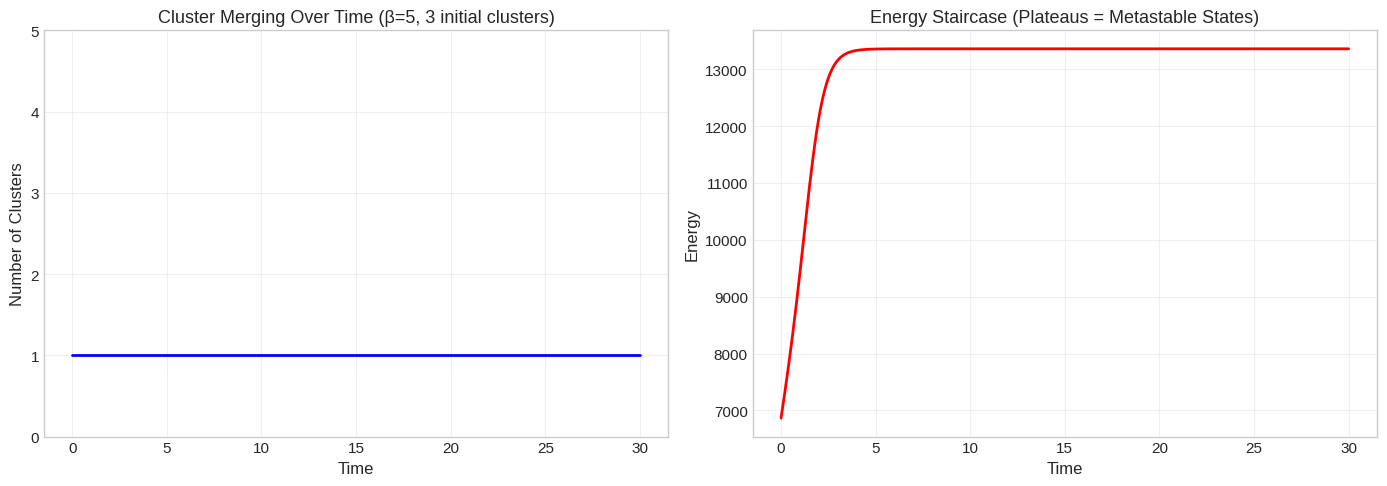

Preview: The 'staircase' pattern shows metastable states.
Notebook 3 will analyze this phenomenon in detail.


In [9]:
# Preview of metastability: cluster merging happens in stages

from utils import clustered_initialization

# Start with 3 distinct clusters
X0_clustered = clustered_initialization(n_clusters=3, n_per_cluster=10, d=3, spread=0.15, seed=42)

beta = 5.0  # High β for clear metastability
t_end = 30.0

times, trajectory = simulate_sa(X0_clustered, beta, (0, t_end), n_steps=300)

# Count clusters over time
cluster_counts = [len(detect_clusters(trajectory[i], 0.9)) for i in range(len(times))]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cluster count over time
axes[0].plot(times, cluster_counts, 'b-', linewidth=2)
axes[0].set_xlabel('Time', fontsize=12)
axes[0].set_ylabel('Number of Clusters', fontsize=12)
axes[0].set_title('Cluster Merging Over Time (β=5, 3 initial clusters)', fontsize=13)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 5)

# Energy staircase
energies = [compute_energy(trajectory[i], beta) for i in range(len(times))]
axes[1].plot(times, energies, 'r-', linewidth=2)
axes[1].set_xlabel('Time', fontsize=12)
axes[1].set_ylabel('Energy', fontsize=12)
axes[1].set_title('Energy Staircase (Plateaus = Metastable States)', fontsize=13)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Preview: The 'staircase' pattern shows metastable states.")
print("Notebook 3 will analyze this phenomenon in detail.")